# 평균모멘텀스코어 현금 혼합 그림 2-26
- 투자 기간 :1986년 1월~2017년 6월
- 투자 대상 : 코스피200지수(코스피200지수 추종 ETF), 현금(3년 만기 국고채=> 이론현금)
- 매수 규칙 : 
  -  주식 : 현금 투자비율 = 주식 1~12개월 평균 모멘텀 스코어:1(현금 평균 모멘텀 비중)
- 매도 규칙 : 매달 말 위의 투자 비중을 새로 계산하여 주식 :현금 투자 비중을 조절하여 반복
- 문제점 : 횡보장(2011.6~2016)
- 10.83%/-33.1%

In [1]:
from settings import *

In [2]:
# 직접생성
# kospi = fdr.DataReader("KS11")['Close']
# df = pd.DataFrame()
# df['KOSPI'] = kospi.copy()
# df = df['1985-1':'2017-6'].resample('MS').first() # 실제 말 마지막날이 공휴일이어도 마지막날 거래 한것과 같이 된다.
# df['현금'] = pow(1.03, 1/12)
# df['현금'] = df['현금'].shift(1, fill_value=1.0)
# df['현금'] = df['현금'].cumprod()
# df

In [3]:
df = pd.read_csv('kospi_m.csv', index_col=0, parse_dates=True)
#-------------------------------------------
df['현금'] = pow(1.03, 1/12)
df['현금'] = df['현금'].shift(1, fill_value=1.0)
df['현금'] = df['현금'].cumprod()
#-------------------------------------------
df.head()

,KOSPI,현금
날짜,,
1985-01-04,1.000,1.000
1985-02-01,0.970,1.002
1985-03-02,0.982,1.005
1985-04-01,0.966,1.007
1985-05-01,0.965,1.010


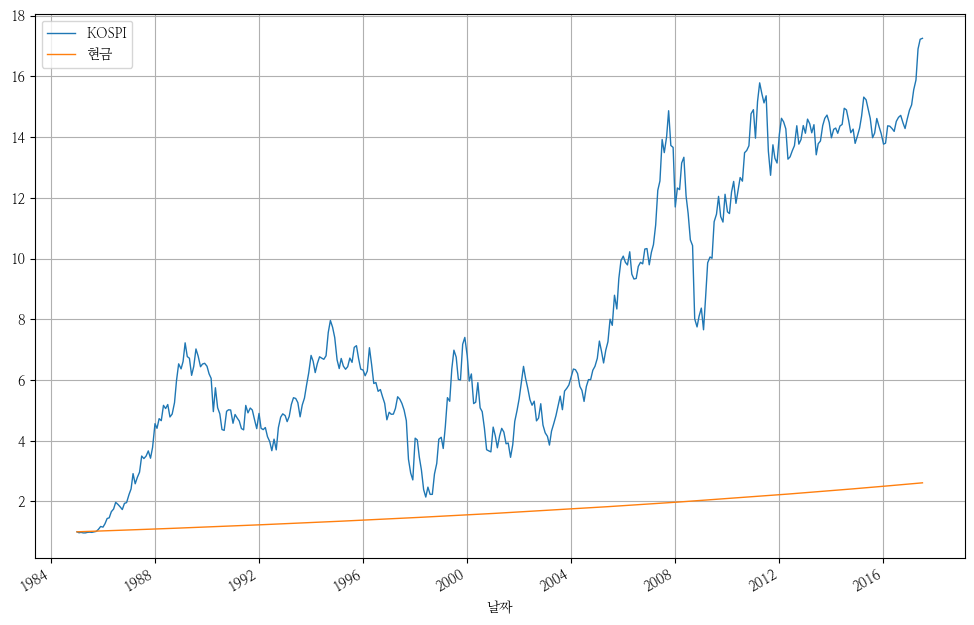

In [5]:
df.rebase(1).plot(figsize=(12,8));

In [6]:
data = df[:'2017-06'].copy()

In [7]:
bt_ew = long_only_ew(data, ['KOSPI', '현금'], "ew")

In [8]:
def 평균모멘텀(데이터):
    초기값 = 0
    for i in range(1, 13):
        초기값 = 데이터 / 데이터.shift(i) + 초기값
    return 초기값 / 12

def 모멘텀순위(데이터, 순위):
    x = 평균모멘텀(데이터)
    y = x.iloc[ : , 0: len(x.columns)].rank(1, ascending=0)
    y[y <= 순위] = 1
    y[y > 순위] = 0
    return y

def 평균모멘텀스코어(데이터):
    a = 평균모멘텀(데이터).copy()
    초기값 = 0
    for i in range(1, 13):
        초기값 = np.where(데이터 / 데이터.shift(i) > 1, 1, 0) + 초기값
    a[a > -1] = 초기값/12
    return a

In [9]:
score = 평균모멘텀스코어(data)

In [10]:
# KOSPI만 평균모멘텀스코어 비중 만큼 투자하고 나머지는 현금
weights0 = pd.DataFrame()
weights0['KOSPI'] = score['KOSPI']
weights0['현금']  = 1.0 - score['KOSPI']
weights0.head(20) # 1986-1 이후 유효

,KOSPI,현금
날짜,,
1985-01-04,NaN,NaN
1985-02-01,NaN,NaN
1985-03-02,NaN,NaN
1985-04-01,NaN,NaN
1985-05-01,NaN,NaN
1985-06-01,NaN,NaN
1985-07-01,NaN,NaN
1985-08-01,NaN,NaN
1985-09-02,NaN,NaN


In [11]:
# 현금도 하나의 자산으로 취급. 이론 현금은 항상 모멘텀스코어가 1이다.
# 따라서 주식 비중이 0.5를 넘을 수 없다.
weights = score.copy()
weights = weights.div(weights.sum(axis=1), axis=0) # !!
weights.head(20)

,KOSPI,현금
날짜,,
1985-01-04,NaN,NaN
1985-02-01,NaN,NaN
1985-03-02,NaN,NaN
1985-04-01,NaN,NaN
1985-05-01,NaN,NaN
1985-06-01,NaN,NaN
1985-07-01,NaN,NaN
1985-08-01,NaN,NaN
1985-09-02,NaN,NaN


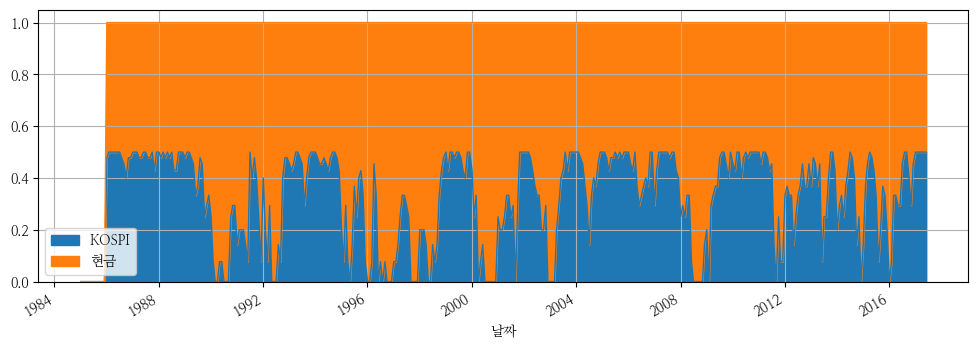

In [13]:
weights.plot.area(figsize=(12,4));

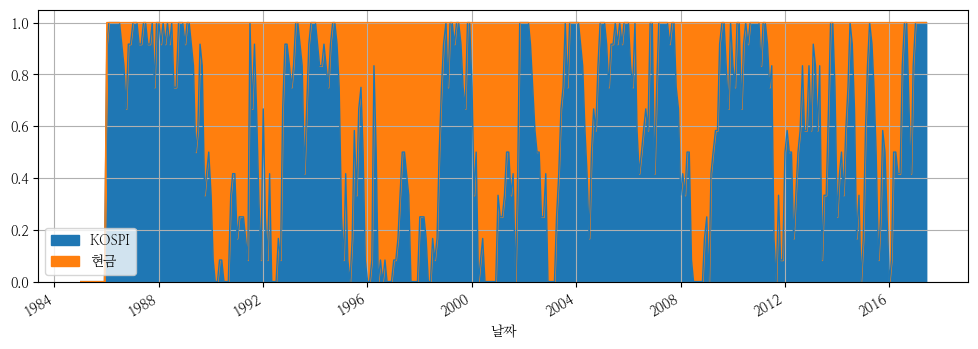

In [14]:
weights0.plot.area(figsize=(12,4));

In [15]:
def momentumscore(data, weights, name="MomScore", start='1986-1-03'):
    st = bt.Strategy(
        name,
        [
            bt.algos.RunMonthly(run_on_last_date=True),
            bt.algos.RunAfterDate(start), #1년 뒤부터 시작 : 시작전 12개월 데이터 필요
            bt.algos.SelectAll(),
            bt.algos.WeighTarget(weights),
            bt.algos.PrintInfo("{now} {_price} {_universe} {temp}"),
            bt.algos.Rebalance()
        ]
    )
    return bt.Backtest(st, data, initial_capital=100000000.0)

In [16]:
# shift(1)을 하면 전달 기준으로 모멘텀 계산
bt_ms0 = momentumscore(data, weights0.dropna(), name='모멘텀 포트폴리오(KOSPI)')#.shift(1))
bt_ms = momentumscore(data, weights.dropna(), name='모멘텀 포트폴리오(현금혼합)')#.shift(1))


In [17]:
bt_kospi = long_only_ew(data, ['KOSPI'], 'KOSPI')
bt_현금 = long_only_ew(data, ['현금'], '현금')

In [18]:
r_ms = bt.run(bt_ms)#, bt_kospi, bt_ew)

1986-01-04 00:00:00 100.0             KOSPI    현금
1985-01-03    NaN   NaN
1985-01-04  1.000 1.000
1985-02-01  0.970 1.002
1985-03-02  0.982 1.005
1985-04-01  0.966 1.007
...           ...   ...
2017-02-01 15.059 2.581
2017-03-02 15.552 2.588
2017-04-03 15.878 2.594
2017-05-02 16.900 2.601
2017-06-01 17.220 2.607

[391 rows x 2 columns] {'selected': ['KOSPI', '현금'], 'weights': KOSPI   0.478
현금      0.522
Name: 1986-01-04 00:00:00, dtype: float64}
1986-02-01 00:00:00 104.74671555753368             KOSPI    현금
1985-01-03    NaN   NaN
1985-01-04  1.000 1.000
1985-02-01  0.970 1.002
1985-03-02  0.982 1.005
1985-04-01  0.966 1.007
...           ...   ...
2017-02-01 15.059 2.581
2017-03-02 15.552 2.588
2017-04-03 15.878 2.594
2017-05-02 16.900 2.601
2017-06-01 17.220 2.607

[391 rows x 2 columns] {'selected': ['KOSPI', '현금'], 'weights': KOSPI   0.500
현금      0.500
Name: 1986-02-01 00:00:00, dtype: float64}
1986-03-03 00:00:00 111.97669858646634             KOSPI    현금
1985-01-03    NaN   NaN


In [19]:
r_ms.set_date_range('1986-1-4')
r_ms.display()

Stat                 모멘텀 포트폴리오(현금혼합)
-------------------  -----------------------------
Start                1986-01-04
End                  2017-06-01
Risk-free rate       0.00%

Total Return         808.96%
Daily Sharpe         -
Daily Sortino        -
CAGR                 7.28%
Max Drawdown         -19.12%
Calmar Ratio         0.38

MTD                  1.07%
3m                   7.53%
6m                   9.43%
YTD                  9.43%
1Y                   11.05%
3Y (ann.)            3.96%
5Y (ann.)            3.00%
10Y (ann.)           3.66%
Since Incep. (ann.)  7.28%

Daily Sharpe         -
Daily Sortino        -
Daily Mean (ann.)    -
Daily Vol (ann.)     -
Daily Skew           -
Daily Kurt           -
Best Day             -
Worst Day            -

Monthly Sharpe       0.82
Monthly Sortino      1.84
Monthly Mean (ann.)  7.45%
Monthly Vol (ann.)   9.14%
Monthly Skew         0.92
Monthly Kurt         2.25
Best Month           10.92%
Worst Month          -5.62%

Yearly Sharpe    

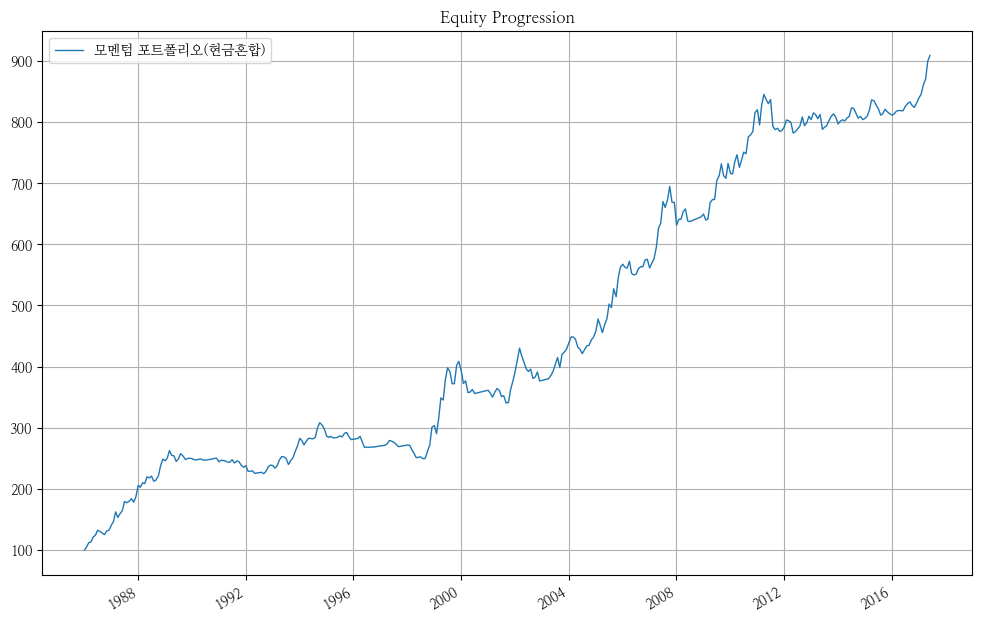

In [20]:
r_ms.plot(figsize=(12,8));

In [21]:
r_all = bt.run(bt_ms, bt_ms0, bt_kospi, bt_ew)

1986-01-04 00:00:00 100.0             KOSPI    현금
1985-01-03    NaN   NaN
1985-01-04  1.000 1.000
1985-02-01  0.970 1.002
1985-03-02  0.982 1.005
1985-04-01  0.966 1.007
...           ...   ...
2017-02-01 15.059 2.581
2017-03-02 15.552 2.588
2017-04-03 15.878 2.594
2017-05-02 16.900 2.601
2017-06-01 17.220 2.607

[391 rows x 2 columns] {'selected': ['KOSPI', '현금'], 'weights': KOSPI   0.917
현금      0.083
Name: 1986-01-04 00:00:00, dtype: float64}
1986-02-01 00:00:00 108.87179685859283             KOSPI    현금
1985-01-03    NaN   NaN
1985-01-04  1.000 1.000
1985-02-01  0.970 1.002
1985-03-02  0.982 1.005
1985-04-01  0.966 1.007
...           ...   ...
2017-02-01 15.059 2.581
2017-03-02 15.552 2.588
2017-04-03 15.878 2.594
2017-05-02 16.900 2.601
2017-06-01 17.220 2.607

[391 rows x 2 columns] {'selected': ['KOSPI', '현금'], 'weights': KOSPI   1.000
현금      0.000
Name: 1986-02-01 00:00:00, dtype: float64}
1986-03-03 00:00:00 123.632710556217             KOSPI    현금
1985-01-03    NaN   NaN
19

In [22]:
r_all.set_date_range('1986-1-4')
r_all.d

Stat                 모멘텀 포트폴리오(현금혼합)    모멘텀 포트폴리오(KOSPI)    KOSPI       ew
-------------------  -----------------------------  --------------------------  ----------  ----------
Start                1986-01-04                     1986-01-04                  1986-01-04  1986-01-04
End                  2017-06-01                     2017-06-01                  2017-06-01  2017-06-01
Risk-free rate       0.00%                          0.00%                       0.00%       0.00%

Total Return         808.96%                        2462.73%                    1390.95%    807.42%
Daily Sharpe         -                              -                           -           -
Daily Sortino        -                              -                           -           -
CAGR                 7.28%                          10.88%                      8.98%       7.27%
Max Drawdown         -19.12%                        -33.07%                     -73.06%     -60.93%
Calmar Ratio         0.38      